### Step 0: Must Run the step below to enable the use of ipyWidgets


In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Button, interactive_output
from IPython.display import display
from matplotlib.colors import LogNorm
import pandas as pd
import os

### Step 1: Prepare and Load Iamges
- Self-defined functions to load your images in the correct format : 'sci_img_2356_f090w_6arcsec.fits'
- define the order of images you want to place
- You can find cutout tools to help you make the cutouts
\
 

> ##### Specific Instructions
> For consistency and simplicity, please make your input cutout file names following the structure below:
> - {extension_name_img_ID_filter_name_size}arcsec.fits
> - For each fits files, we would require the primary extension [0]

> **Required:**
> - `extension_name` are `sci`, `wht`, `err`, `bkgd`, etc.
> - `filter_name` examples: `f435w`, `f606w`, `f410m`, etc.
> - `ID` is a self-defined identifier for your source. Better be a pure number. At least, please don't include '_' in the ID part.

> **Optional:**  
> - `{size}arcsec` can be optional.

> **E.g.**, 'sci_img_2356_f090w_6arcsec.fits'

In [3]:
_images_cache = {}
_headers_cache = {}
def load_iamges(ID = None, extension = 'sci',filters_to_load = None, opt_info = '6arcsec', input_dir = None):
    """load images for selected ID"""
    import os
    from astropy.io import fits
    output = {}
    output_header = {}
    if ID not in _images_cache:
        for item in filters_to_load:
            img_path =  os.path.join(input_dir, f'{extension}_img_{ID}_{item}_{opt_info}.fits')
            with fits.open(img_path) as hdu:
                output[item] = hdu[0].data
                output_header[item] = hdu[0].header.copy()

        _images_cache[ID] = output 
        _headers_cache[ID] = output_header

    return _images_cache[ID], _headers_cache[ID]

In [4]:
#Example:
ID = 2356
extension = 'sci'
filters_to_load = ['f435w', 'f606w', 'f814w', 'f090w', 'f115w','f150w','f200w','f277w','f356w','f410m', 'f444w']
opt_info = '6arcsec'
input_dir = './test_case'

#it's only a test to make sure images are loaded correctly, you don't need to load images yourself, the function is called inside the classification
images, headers  = load_iamges(ID = ID, extension = extension ,filters_to_load = filters_to_load, opt_info = opt_info , input_dir =input_dir)

### Step 2: Prepare info of IDs, Redshifts and Additonal Info into a dict
- IDs are required, please load it into a list in your desired order if you have one
- Redshifts are otpional, but once you previded, it can provide rest frame -> observatinal frame info that may help your identificaiton
- Any additional info you want to include 
\
 

In [5]:
#mannually define what infos you want to present
#ID
IDs = [2356, 17989]

#Redshift
#Please use None specifically to aviod error
redshift_dict = {2356: 1.12,
    17989: None ,
    62434: 1.22,
     26433: 1.54,
   30155: 2.13,
    28886: 2.32}

for key in IDs:
    if key not in redshift_dict.keys():
        redshift_dict[key] = None #Mannually set not defined redshifts to None to avoid error

#self difined info
additional_info_dict = {}
for item in IDs:
    additional_info_dict[item] = ''

#Don't modify this
ID_index = {'i': 0}  # mutable dict so closures can modify

if 'output_results_for_all' not in globals(): #prevent auto-overwriting it
    output_results_for_all = {}




In [6]:
#Do this in a seperate cell allows you to change this without losing existing results
output_results_file_name = './output_results.csv'

### Step 3: Define your own classifcation Regime, Actions (Buttons & Sliders) and Layout

#### Tabs & Radio Buttons -  Main Classification Selections
Each of the button is a single-selection button, so please design your classfication regime with respect to it

There are two kinds of radio buttons:
- `Always-visible Buttons` that will always show in a tab:  e.g., `Galaxy_type`, `disk_morphology`, `bar_selection_1`, `bar_selection_2` 
- `Conditional Buttons` only shown if satisfied certain condition: e.g., `inclined_disk_radio` only appear if you select `Disk-Dominated` in the `Galaxy_type` selection

- If the button is not selected, it will record the default value 'Not Selected'. Classifier don't need to go through all the tabs if they are not related. E.g., if `Galaxy_type` is `Unresolved`, the classifiers don't need to select `disk_morphology`, `etc.`

Always include a `comments` comment box for peronalized notes.

**💡 Note:**  
All ** Radio Buttons** will be organized within a **Tab widget** to save space and keep the layout clean.

In [7]:
#################################################### ######################################################
################################# Basic selections ##########################################################
################################# Always-visible Buttons ####################################################


### In the classification, not all needs to be selected

Galaxy_type = widgets.RadioButtons(
    options=['Spheroid-Dominated','Disk-Dominated', 'Irregular','Mergers','Unresolved','Contaminated/Unclassifiable','Not Selected'],
    layout={'width': 'max-content'}, # If the items' names are long
    description='Galaxy Type:', #name of the button
    disabled=False,
    value = 'Not Selected' #default values
)

disk_morphology = widgets.RadioButtons(
    options=['Sprials','>2 Sprials', 'Ring', 'Clumpy','Asymetric/Disturbed', 'Not Selected'],
    layout={'width': 'max-content'}, # If the items' names are long
    description='Galaxy Type:',
    value = 'Not Selected',
    disabled=False
)

bar_selection_1 = widgets.RadioButtons(
    options=['Confident-Barred', 'Likely-Barred','Unsure-Barred', 'UnBarred', 'Failed to classify', 'Not Selected'],
    layout={'width': 'max-content'}, # If the items' names are long
    description='Bar Types F200W:',
    value = 'Not Selected',
    disabled=False
)

bar_selection_2 = widgets.RadioButtons(
    options=['Confident-Barred', 'Likely-Barred','Unsure-Barred', 'UnBarred', 'Failed to classify', 'Not Selected'],
    layout={'width': 'max-content'}, # If the items' names are long
    description='Bar Types:F444W',
    value = 'Not Selected',
    disabled=False
)

################################# Always-visible Buttons End ########################################################
####################################################################################################################




#######################################################################################################################
################################# Conditional Buttons ##################################################################

### `Conditional Buttons` e.g., Inclined Disk
#I want this as an extra piece of information, and only appear if the galaxy is considered a disk galaxy

second_box = widgets.VBox([]) #create an empty box as a placeholder for the `Conditional Buttons`
inclined_disk_radio = widgets.RadioButtons(
                options=['Inclined Disk', 'Low-to-Moderately Disk','Not Selected'],
                description='Inclination:',
                layout={'width': 'max-content'},
                value = 'Not Selected',
                disabled = False
            )

def disk_dominated_change(change):
    """Function to observe if the Disk_Dominated is selected in Galaxy type
    IF so, make 'inclined_disk_ratio' button to appear. """
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == 'Disk-Dominated':
            
            second_box.children = [inclined_disk_radio]
        else:
            second_box.children = []

Galaxy_type.observe(disk_dominated_change)

################################# Conditional Buttons End ##################################################################
###########################################################################################################################




##############################################################################################################################
################################# Text Widgets  ##################################################################################
#comment box

comments = widgets.Text(description = 'Comments',value = 'no comments')

#Used to input ID for 'Check' Action
ID_go_to = widgets.Text(description = 'ID')
################################# Comment Box  ##################################################################################
#################################################################################################################################




################################################################################################################################
################################# Create the Tab  ##################################################################################

#Orginize your buttons into a dict with your desired names, keep it consistent throughout
buttons_dict = {'Galaxy_type': Galaxy_type,
                'Inclined_disk': inclined_disk_radio,
                'Disk Morphology': disk_morphology,
                'Bar Type F200W': bar_selection_1,
                'Bar Type F444W': bar_selection_2,
                'comments':comments}



#put the Always-Visible buttons & comment box in a Tab Widget
tab_contents = ['Galaxy Type', 'Disk Morphology', 'Bar Type F200W', 'Bar Type F444W', 'Comments']

children = [VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"),HBox([Galaxy_type, second_box])]), #add a current galaxy guidence for classfication;
                                                                                                            # include the second_box for your conditional button
            VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"),disk_morphology]),
            VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"),bar_selection_1]),
            VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"),bar_selection_2]),
            VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"),comments])]             
tab = widgets.Tab(layout=widgets.Layout(width='500px',   # fixed width
        height='300px',  # fixed height
        overflow='auto',))
tab.children = children
for i, title in enumerate(tab_contents):
    tab.set_title(i, title)

################################# Create the Tab  ##################################################################################
################################################################################################################################



#### Interactive Functions/Actions --  Sliders
<div style="
    border: 2px solid #e39611ff; 
    background-color: #fe8e5aff; 
    padding: 15px; 
    border-radius: 10px; 
    width: 70%; 
    margin: 20px auto; 
    text-align: center;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial;
    font-size: 1.05em;
">
<strong>⚡ Main Strength of This Notebook:</strong><br>
Classifications are guided by the appearance of the images. Finding the optimal stretch — or, in simpler terms, adjusting the contrast — allows classifiers to better identify structures within the images. Allowing users to dynamically adjust the stretch/contrast can significantly improve the accuracy and ease of classification.
</div>



I provided 4 example buttons below, including basic functions to:

- **`vmin_slider`**
- - Change the vmin of the Log-stretch scale, value is the ` np.nanpercentile(input_data, vmin_percent)`.

- **`vmax_slider`**
- - Change the vmax of the Log-stretch scale, value is the ` np.nanpercentile(input_data, vmax_percent)`.

- **`contour_levels_slider`**
- - Add contours to help visualizing structure, value is number of levels `np.linspace(np.nanmin(input_data), np.nanmax(input_data), int(contour_levels))`

- **`zoomin_slider`**
- - Zoom in the central region of all cutouts. If you only care about one, you can drag and zoom in the image with tool bars from matplotlib widget.


In [8]:
from ipywidgets import interact, FloatSlider

def labeled_slider(min, max, value, step, label, slider_cls=widgets.FloatSlider, border_color = "#85D5F5"):
    """Formatting the slider"""
    slider = slider_cls(
        min=min,
        max=max,
        step=step,
        value=value,
        continuous_update=False,
        description='',  # hide default description
        layout=widgets.Layout(width="250px")
    )

    input_layout  = widgets.Layout(
                           border=f'2px solid {border_color}',
                           padding='5px',
                           margin='3px',
                           border_radius='5px'
                       )

    caption = widgets.HTML(f"<div style='text-align:center; font-size:15px;'>{label}</div>")
    return widgets.VBox([slider, caption], layout = input_layout), slider

# Example sliders
vmin_box, vmin_slider = labeled_slider(0.1, 100, 0.1, 0.1, "vmin%")
vmax_box, vmax_slider = labeled_slider(0.1, 100, 100, 0.1, "vmax%")
contour_box, contour_levels_slider = labeled_slider(0, 20, 0, 1, "contours", slider_cls=widgets.IntSlider)
zoomin_box, zoomin_slider = labeled_slider(1, 10, 1, 0.5, "zoomin")

# dicts for sliders:
sliders_dict = {'vmin': vmin_slider, 'vmax': vmax_slider,
                'contour': contour_levels_slider, 'zoom': zoomin_slider}
sliders_default_value = {'vmin':0.1, 'vmax':100, 'contour':0, 'zoom':1}



#### Interactive Functions/Actions --  Buttons
> I provided 6 example buttons below, including basic functions to:

- **`button_previous`**: 
- - Navigate to the previous source in your `IDs` list. If you are at the first source (`source_index = 0`), it will wrap around to the last source.
- - If source alreay have classifcations, the `Summary box` will show already saved results, and classifcations set to saved values.

- **`button_next`**: 
- - Navigate to the next source in your `IDs` list. If you are at the last source (`source_index = -1`), it will wrap around to the first source.
- - If source alreay have classifcations, the `Summary box` will show already saved results, and classifcations set to saved values.

- **`button_save`**
- - Save your current classifications.  
- - Upon successful saving the current classifications, the **Summary** box will display a summary of the saved results.  
- - To update classifications, change your selections and click **Save Current** again.
- - ⚠️ **IMPORTANT:** Selected classifications are saved **only after clicking the "Save Current" button**.  

- **`button_check`**
- - Load a desired galaxy by entering its ID. You are not limited by next/previous function by doing this way  
- - If classifications for that galaxy have been saved previously, the widgets will populate with those results. **Note:** This does **not** overwrite existing saved results.

- **`button_export`**
- - Export all saved classifications to a CSV file named `<output_results_file_name>`. If `<output_results_file_name>` exists, exporting process will be failed.

- **`button_confirm`**
- - Used in `button_check` to confirm if the input ID is the one you want to go to.


In [9]:
#Buttons
button_previous = Button(description="Previous", style={'button_color':"#85F5B4", 'font_weight':'normal'}, layout=widgets.Layout(width='100px', height='40px'))
button_next = Button(description="Next", style={'button_color':"#85D5F5", 'font_weight':'normal',}, layout=widgets.Layout(width='100px', height='40px'))
button_save = Button(description="Save Current", style={'button_color':"#FDF07E", 'font_weight':'normal',}, layout=widgets.Layout(width='100px', height='40px'))
button_check = Button(description="Check", style={'button_color':"#F88AD5", 'font_weight':'normal', }, layout=widgets.Layout(width='100px', height='40px'))
button_export = Button(description="Export Results", style={'button_color':"#FEB257", 'font_weight':'normal'}, layout=widgets.Layout(width='130px', height='40px'))
button_confirm = Button(description="Confirm", style={'button_color':"#FEB257", 'font_weight':'normal'}, layout=widgets.Layout(width='130px', height='40px'))
button_save_confirm = Button(description="Yes", style={'button_color':"#8BDCF7", 'font_weight':'normal'}, layout=widgets.Layout(width='100px', height='80px'))
button_exit_confirm = Button(description="No", style={'button_color':"#F680AB", 'font_weight':'normal'}, layout=widgets.Layout(width='100px', height='80px'))


#### Design the Layout of Widgets

In [10]:
# Lay out
sliders_box = HBox([VBox([vmin_box, vmax_box]), VBox([contour_box, zoomin_box])])
button_box = HBox([button_previous, button_next, button_save, button_export, button_check]) #button_clear

summary_box = widgets.VBox([widgets.HTML("Summary:"),button_save_confirm,button_exit_confirm], layout = widgets.Layout(width='300px',   # fixed width
        height='300px',  # fixed height
        overflow='auto',border=f'2px solid #85D5F5', padding='5px', margin='3px', border_radius='5px'))

show_preview = True #set this to True if you want a preview
if show_preview:
    display(HBox([ HBox([VBox([sliders_box,button_box]), tab, summary_box])]))

### Step 4: Define your Plotting


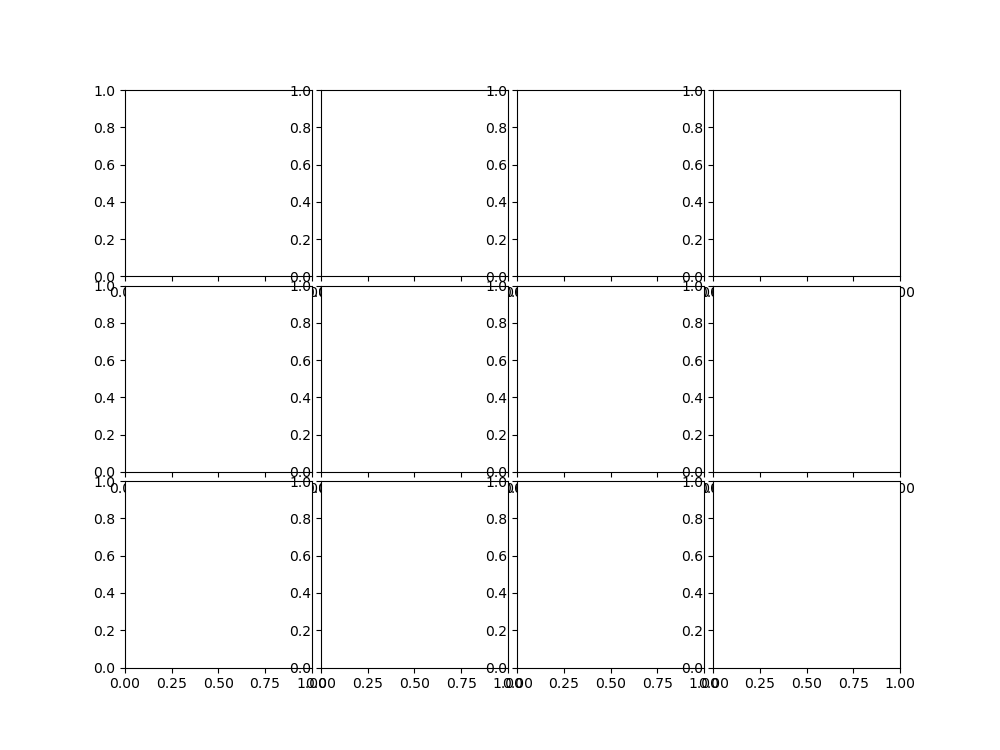

In [12]:
# --- Prepare figure ---

ncol = 4 #
nrow = int(len(images.keys())/ncol) + 1

plt.close('all')

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*2.5, nrow*2.5))
axs = axs.flatten()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig_out = widgets.Output()


def return_lognorm(data=None, vmin_percent=0.1, vmax_percent=100):
    """Return the scales, default in Log for images"""
    input_data = data - np.nanmin(data) + 1e-6
    vmin = np.nanpercentile(input_data, vmin_percent)
    vmax = np.nanpercentile(input_data, vmax_percent)
    if vmin <= 0:
        raise ValueError(f"vmin={vmin:.3g} ≤ 0, cannot use LogNorm.")
    if vmin >= vmax:
        raise ValueError(f"Invalid percentiles: vmin={vmin:.3g} ≥ vmax={vmax:.3g}")
    return LogNorm(vmin=vmin, vmax=vmax)

def plot_cutouts(images, vmin_percent=0.1, vmax_percent=100, contour_levels=3, zoomin=1, ID=None, fig = None, axs = None):
    fig_out = widgets.Output()
    with fig_out:
        for ax in axs:
            ax.cla()
        for i, key in enumerate(images.keys()):
            x, y = np.array(images[key].data).shape
            x, y = x//2, y//2
            x0, xe = x - int(x/zoomin), x + int(x/zoomin)
            y0, ye = y - int(y/zoomin), y + int(y/zoomin)
            input_data = np.array(images[key].data)[x0:xe, y0:ye]
            norm = return_lognorm(input_data, vmin_percent, vmax_percent)
            axs[i].imshow(input_data, norm=norm, origin='lower')
            axs[i].text(0.05, 0.05, f'{key}', transform=axs[i].transAxes,
                        fontsize=8, va='bottom', ha='left',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", edgecolor="black"))
            if contour_levels > 0:
                levels = np.linspace(np.nanmin(input_data), np.nanmax(input_data), int(contour_levels))
                axs[i].contour(input_data, levels=levels, linewidths=1, colors='red')
        
        for ax in axs:
            ax.axis("off")
            if not ax.has_data():
                ax.set_visible(False)

        # Suptitle 
        if redshift_dict.get(ID) is not None:
            z = redshift_dict[ID]
            fig.suptitle(f'Galaxy ID: {ID} at z: {z}\n'
                        f'rest-frame UV (~1000-3000 Å) → Observed: {1000*(z+1)}-{3000*(z+1)} Å\n'
                        f'rest-frame Optical (~4000-8000 Å) → Observed: {4000*(z+1)}-{8000*(z+1)} Å\n'
                        f'rest-frame NIR (>10000 Å) → Observed: >{10000*(z+1)} Å', fontsize = 11)
        else:
            fig.suptitle(f'Galaxy ID: {ID} \n No Redshift Provided')
        #plt.close(fig)
        fig.canvas.draw_idle()

    return None

# an empty figure will show b/c we called fig here

### Step 5: Define your Actions for each Button and Plot

In [13]:
################################################################################################################################
### Define the general actions #####


################################################################################################################################
#Generate the plots


def update(vmin_percent, vmax_percent, contour_levels, zoomin):
    ID = IDs[ID_index['i']]
    
    data, header = load_iamges(ID=ID, extension=extension,
                               filters_to_load=filters_to_load,
                               opt_info=opt_info, input_dir=input_dir)
    with fig_out:
        plot_cutouts(data, vmin_percent, vmax_percent, contour_levels, zoomin, ID=ID, fig = fig, axs = axs) #fig and axs defined globally

#1. Clean current slider selections for the next/previous/selected source
def clean_sliders():
    """clean the current slider values to default"""
    for key in sliders_dict.keys():
        sliders_dict[key].value = sliders_default_value[key]

def show_existing_classifications(input_ID_str):
    """ If the classifications are already saved for the current galaxy
    Show them in the Summary Box """
    output_keys_str = list(map(str, output_results_for_all.keys()))
    idx_in_dict = output_keys_str.index(input_ID_str)
    data_dict = list(output_results_for_all.values())[idx_in_dict]
    emp_str = ''
    for key, item in data_dict.items():
        emp_str += f'{key}: {item} <br>'
    
    summary_box.children = [widgets.HTML(f'Already Saved Results:<br>'+f" <b>Galaxy ID = {IDs[ID_index['i']]}</b> <br>"
                                +emp_str)]
    
    return data_dict


def refresh_tab_labels():
    """refresh_tab_labels 
    Please make sure the children below is the same as you defined in Section 3, or you want to modify this function to update certain children/tab"""
    
    children = [
        VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"), HBox([Galaxy_type, second_box])]),
        VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"), disk_morphology]),
        VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"), bar_selection_1]),
        VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"), bar_selection_2]),
        VBox([widgets.HTML(f"Current Galaxy: {IDs[ID_index['i']]}"), comments])
    ]
    tab.children = children


def recall_classifications(input_dict):
    """ If the classifications are already saved for the current galaxy
    Set the selections to the save values for this galaxy """
    for key, item in buttons_dict.items():
        item.value = input_dict[key]
    refresh_tab_labels()


def reset_classifications():
    """ If the classifications are not saved for the current galaxy before
    Set the selections to the default values """

    Galaxy_type.value = "Not Selected"
    inclined_disk_radio.value = "Not Selected"
    disk_morphology.value = "Not Selected"
    bar_selection_1.value = "Not Selected"
    bar_selection_2.value = "Not Selected"
    comments.value = "no comments"  # clear comments
    refresh_tab_labels()


def save_single_Galaxy():
    """save classification results for a single galaxy to a dict"""
    single_galaxy_dict = {'ID' : IDs[ID_index['i']]}
    for key, item in buttons_dict.items():
        single_galaxy_dict[key] = item.value
    return single_galaxy_dict


def export_results(input):
    """Write the current results to a pandas data frame"""
    columns = list(list(input.values())[0].keys())
    df = pd.DataFrame(columns=columns)
    for key in input.keys():
        #columns are  Galaxy_type, Inclined_disk, Disk_Morphology, bar type, bar 
        new_row = input[key]
        df.loc[len(df)] = new_row   # append a new row

        # export
    return df


def return_warning_message(filename):
    """Warning message for overwriting an existing output file"""
    warning_message = f"""
            <div style="
                border-left: 6px solid #f0ad4e;
                background: #fff3cd;
                color: #856404;
                padding: 12px;
                border-radius: 6px;
                font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial;
                ">
                <strong style="font-size:1.05em;">⚠️ Warning</strong>
                <div style="margin-top:6px;">
                    File: <code style="background: rgba(0,0,0,0.04); padding:2px 6px; border-radius:4px;">{filename}</code>
                    already exists. <br> If you still want to continue, click 'YES' below. <br> If you do not want to continue, click 'NO', and change the output_results_file_name variable or delete the previous file.
                </div>
            </div>
            """
    return warning_message

####### Action for each button ####### ####### ####### ####### ####### ####### ####### ####### 

# --- Clear all button callbacks since you may run this cell multiple times #
for btn in [button_next, button_previous, button_save, button_export, button_check, button_confirm, button_exit_confirm, button_save_confirm]:
    btn._click_handlers.callbacks = []

# Button_next

def on_next_clicked(b):
    """ Go to the next source """
    ID_index['i'] = (ID_index['i'] + 1) % len(IDs) # go to your next 
    clean_sliders()

    output_keys_str = list(map(str, output_results_for_all.keys()))      
    if str(IDs[ID_index['i']]) in output_keys_str: #if results are saved before

        data_dict = show_existing_classifications(str(IDs[ID_index['i']])) # show summary in the Summary box
        recall_classifications(data_dict) #update selection based on saved results
    else:
        reset_classifications() #set to default results
        summary_box.children = [widgets.HTML(f"No Previous Saved Results for {IDs[ID_index['i']]}")]
    #update the plot
    update(vmin_slider.value, vmax_slider.value, contour_levels_slider.value, zoomin_slider.value)

button_next.on_click(on_next_clicked)


# Button_previous

def on_previous_clicked(b):
    """ Go to the previous source """
    ID_index['i'] = (ID_index['i'] - 1) % len(IDs)
    clean_sliders()

    output_keys_str = list(map(str, output_results_for_all.keys()))      
    if str(IDs[ID_index['i']]) in output_keys_str: #if results are saved before

        data_dict = show_existing_classifications(str(IDs[ID_index['i']])) # show summary in the Summary box
        recall_classifications(data_dict) #update selection based on saved results
    else:
        reset_classifications() #set to default results
        summary_box.children = [widgets.HTML(f"No Previous Saved Results for {IDs[ID_index['i']]}")]
    #update the plot
    update(vmin_slider.value, vmax_slider.value, contour_levels_slider.value, zoomin_slider.value)

button_previous.on_click(on_previous_clicked)

#Button Save

def on_save_clicked(b):
    """Save the current results, Do this for every source"""
    output_dict = save_single_Galaxy()
    output_results_for_all[IDs[ID_index['i']]] = output_dict
    emp_str = ''
    for key, item in output_dict.items():
        emp_str += f'{key}: {item} <br>'
 
    summary_box.children = [widgets.HTML(f" <b>Galaxy ID = {IDs[ID_index['i']]}</b> <br>"
                                         +emp_str)]
    
button_save.on_click(on_save_clicked)

#Button export

def on_export_clicked(b):
    
    """Export the saved results to a CVS file"""

    df = export_results(output_results_for_all)
    if os.path.exists(output_results_file_name):
        warning_message = return_warning_message(output_results_file_name)
        summary_box.children = [VBox([widgets.HTML(warning_message), HBox([button_save_confirm, button_exit_confirm])]) ]#f"{output_results_file_name} Existed Already <br> File Existed, Export Failed.")]
        #print('File Existed, Export Failed.')
    else:
        df.to_csv(output_results_file_name , index=False)
        print('File Sasved Successfully.')

button_export.on_click(on_export_clicked)

#Button save confrim

def on_save_confirm_clicked(b):
    
    """OVERWRITE the saved results to a CVS file"""

    df = export_results(output_results_for_all)
    df.to_csv(output_results_file_name , index=False)
    summary_box.children  = [widgets.HTML(f'{output_results_file_name} Saved Successfully.')]

button_save_confirm.on_click(on_save_confirm_clicked)

#Button exit confrim

def on_exit_confirm_clicked(b):
    """Quit the current page """
    summary_box.children  = [widgets.HTML(f'Export failed, file already existed: {output_results_file_name} ')]

button_exit_confirm.on_click(on_exit_confirm_clicked)


#Button check

def on_check_clicked(b):
    """Click Check, input the ID for inquiring a certain Galaxy"""
    summary_box.children = [VBox([ID_go_to,button_confirm])]

button_check.on_click(on_check_clicked)


#Button Confirm
def on_confirm_clicked(b):
    """Confirm the input ID, for checking the Results"""

    with fig_out:
        ID_to_go  = ID_go_to.value   # note the variable name is ID to go, and the widget name is ID_go_to !
        str_IDs = list(map(str, IDs))
        if str(ID_to_go) in str_IDs:
            idx = str_IDs .index(ID_to_go)
            ID_index['i'] = (idx) % len(IDs)

            output_keys_str = list(map(str, output_results_for_all.keys()))
            
            if str(ID_to_go) in output_keys_str:
                
                data_dict = show_existing_classifications(str(IDs[ID_index['i']])) # show summary in the Summary box
                recall_classifications(data_dict) #update selection based on saved results
                clean_sliders()
                update(vmin_slider.value, vmax_slider.value, contour_levels_slider.value, zoomin_slider.value)
    
            else:
                summary_box.children = [widgets.HTML(f'Goes to ID {ID_to_go} <br> No previous saved results found')]
                clean_sliders()
                reset_classifications()
                update(vmin_slider.value, vmax_slider.value, contour_levels_slider.value, zoomin_slider.value)
        
        else:
            summary_box.children = [widgets.HTML('Input ID is not found in provided IDs')]#f"{output_results_file_name} Existed Already <br> File Existed, Export Failed.")]
    
button_confirm.on_click(on_confirm_clicked)




#### Interactive output
ui = interactive_output(update,
                        {'vmin_percent': vmin_slider, 'vmax_percent': vmax_slider,
                         'contour_levels': contour_levels_slider, 'zoomin': zoomin_slider})

In [14]:
agree = False
if agree:   
    output_results_for_all = {} #mannually forced restart

### Step 6: Run the Cell below and start your classifications

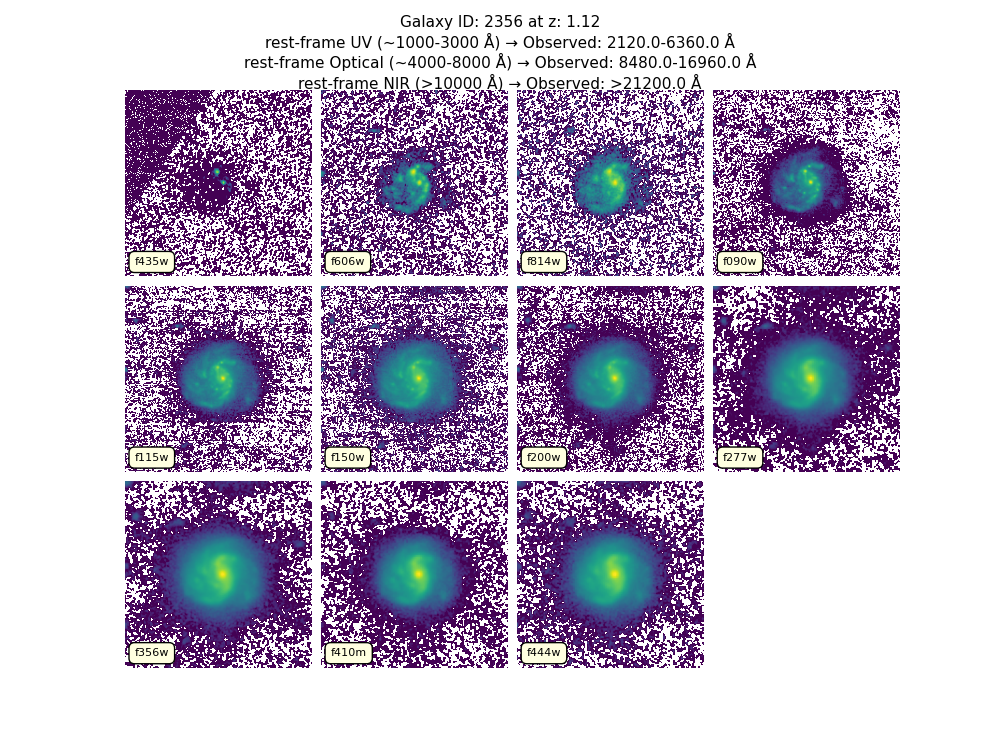

In [15]:

#close the plot to avoid too much ploting
fig_out = widgets.Output()
display(HBox([ HBox([VBox([sliders_box,button_box]), tab, summary_box])]))
fig.canvas
